In [1]:
import os
import numpy as np
import pandas as pd
from pandas import read_csv, DataFrame
from matplotlib import pyplot as plt
import datetime as dt
from dataset.electricity_dataset import electricity_pre
from datetime import datetime
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import Sampler, SubsetRandomSampler
import random
import properscoring as ps
from statistics import mean

In [2]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

In [3]:
warnings.filterwarnings('ignore')
now = datetime.now()
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [4]:
np.set_printoptions(precision=4)

In [5]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y")
print("date and time =", dt_string)	

date and time = 23-11-2022


In [6]:
#for debugging
gc =0
GC=[]

In [7]:
agg_traffic = pd.read_csv('agg_traffic.csv')
agg_mat_max = agg_traffic.values
agg_mat_max = agg_mat_max[:,1:]
AG=agg_mat_max[:7].astype(int)

In [8]:
AG

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [9]:
def date_cv(x):
    return datetime.strptime(x, '%Y-%m-%d')
data = pd.read_csv("trffc.csv", header=None, skiprows=[0], parse_dates = [[0]], date_parser=date_cv)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,2008-01-01,1536.0182,757.3218,778.6964,360.5690,396.7528,410.6807,368.0157,8.1370,2.1910,...,5.5609,5.2466,9.3058,8.7667,5.8731,11.3673,8.8627,8.1654,6.5542,8.5484
1,2008-01-02,1619.2435,790.8156,828.4279,389.4334,401.3822,431.6908,396.7371,8.9488,8.1517,...,5.3390,5.3748,9.7310,12.0854,5.9546,11.8716,9.1413,8.2749,7.9835,7.4303
2,2008-01-03,1423.6574,684.3216,739.3358,329.0994,355.2222,387.1702,352.1656,8.1359,4.7902,...,5.1115,5.1326,9.6746,8.9663,6.1468,9.7029,8.5609,7.8705,6.2287,6.7340
3,2008-01-04,1096.3325,529.1279,567.2046,249.3346,279.7933,296.2565,270.9481,6.4700,1.5121,...,2.9545,3.8832,6.7228,6.5009,4.7770,7.6188,7.4227,5.5232,4.8793,5.8216
4,2008-01-05,974.5526,475.1733,499.3793,231.4860,243.6873,264.9305,234.4488,5.5741,1.4916,...,2.5862,3.6739,5.5844,5.7266,4.0254,6.4069,6.9933,5.1315,4.0133,5.2404


In [10]:
#data.drop('Unnamed: 0', axis=1, inplace=True)

In [11]:
data = data.rename({'0': 'date'}, axis='columns')
data[["date"]] = data[["date"]].apply(pd.to_datetime)

In [12]:
data

,date,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,2008-01-01,1536.0182,757.3218,778.6964,360.5690,396.7528,410.6807,368.0157,8.1370,2.1910,...,5.5609,5.2466,9.3058,8.7667,5.8731,11.3673,8.8627,8.1654,6.5542,8.5484
1,2008-01-02,1619.2435,790.8156,828.4279,389.4334,401.3822,431.6908,396.7371,8.9488,8.1517,...,5.3390,5.3748,9.7310,12.0854,5.9546,11.8716,9.1413,8.2749,7.9835,7.4303
2,2008-01-03,1423.6574,684.3216,739.3358,329.0994,355.2222,387.1702,352.1656,8.1359,4.7902,...,5.1115,5.1326,9.6746,8.9663,6.1468,9.7029,8.5609,7.8705,6.2287,6.7340
3,2008-01-04,1096.3325,529.1279,567.2046,249.3346,279.7933,296.2565,270.9481,6.4700,1.5121,...,2.9545,3.8832,6.7228,6.5009,4.7770,7.6188,7.4227,5.5232,4.8793,5.8216
4,2008-01-05,974.5526,475.1733,499.3793,231.4860,243.6873,264.9305,234.4488,5.5741,1.4916,...,2.5862,3.6739,5.5844,5.7266,4.0254,6.4069,6.9933,5.1315,4.0133,5.2404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2008-12-27,1606.0017,801.1668,804.8349,423.0887,378.0781,408.4916,396.3433,7.7495,9.0067,...,11.3703,7.0951,5.6765,6.8699,5.4110,8.9070,4.3274,2.6546,12.9457,13.0458
362,2008-12-28,1567.3015,779.7629,787.5386,413.3880,366.3749,395.4527,392.0859,8.1097,9.2325,...,11.0934,7.4894,7.5004,7.0521,5.5878,9.2178,4.4601,2.6299,13.1887,11.6035
363,2008-12-29,1722.5124,878.3538,844.1586,428.7631,449.5907,429.9540,414.2046,6.2941,5.9546,...,12.2824,7.6019,5.7080,6.9409,8.5787,7.2745,10.6823,2.8012,14.2313,13.4012
364,2008-12-30,1776.7038,918.6770,858.0268,475.8637,442.8133,421.0122,437.0146,9.7905,9.3584,...,12.1320,7.1799,6.5667,7.5545,2.8586,10.3623,8.6429,2.8779,14.2212,13.3731


In [13]:
data["dow"]=data['date'].dt.dayofweek
data["dom"]=data['date'].dt.day

In [14]:
data

,date,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,dow,dom
0,2008-01-01,1536.0182,757.3218,778.6964,360.5690,396.7528,410.6807,368.0157,8.1370,2.1910,...,9.3058,8.7667,5.8731,11.3673,8.8627,8.1654,6.5542,8.5484,1,1
1,2008-01-02,1619.2435,790.8156,828.4279,389.4334,401.3822,431.6908,396.7371,8.9488,8.1517,...,9.7310,12.0854,5.9546,11.8716,9.1413,8.2749,7.9835,7.4303,2,2
2,2008-01-03,1423.6574,684.3216,739.3358,329.0994,355.2222,387.1702,352.1656,8.1359,4.7902,...,9.6746,8.9663,6.1468,9.7029,8.5609,7.8705,6.2287,6.7340,3,3
3,2008-01-04,1096.3325,529.1279,567.2046,249.3346,279.7933,296.2565,270.9481,6.4700,1.5121,...,6.7228,6.5009,4.7770,7.6188,7.4227,5.5232,4.8793,5.8216,4,4
4,2008-01-05,974.5526,475.1733,499.3793,231.4860,243.6873,264.9305,234.4488,5.5741,1.4916,...,5.5844,5.7266,4.0254,6.4069,6.9933,5.1315,4.0133,5.2404,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2008-12-27,1606.0017,801.1668,804.8349,423.0887,378.0781,408.4916,396.3433,7.7495,9.0067,...,5.6765,6.8699,5.4110,8.9070,4.3274,2.6546,12.9457,13.0458,5,27
362,2008-12-28,1567.3015,779.7629,787.5386,413.3880,366.3749,395.4527,392.0859,8.1097,9.2325,...,7.5004,7.0521,5.5878,9.2178,4.4601,2.6299,13.1887,11.6035,6,28
363,2008-12-29,1722.5124,878.3538,844.1586,428.7631,449.5907,429.9540,414.2046,6.2941,5.9546,...,5.7080,6.9409,8.5787,7.2745,10.6823,2.8012,14.2313,13.4012,0,29
364,2008-12-30,1776.7038,918.6770,858.0268,475.8637,442.8133,421.0122,437.0146,9.7905,9.3584,...,6.5667,7.5545,2.8586,10.3623,8.6429,2.8779,14.2212,13.3731,1,30


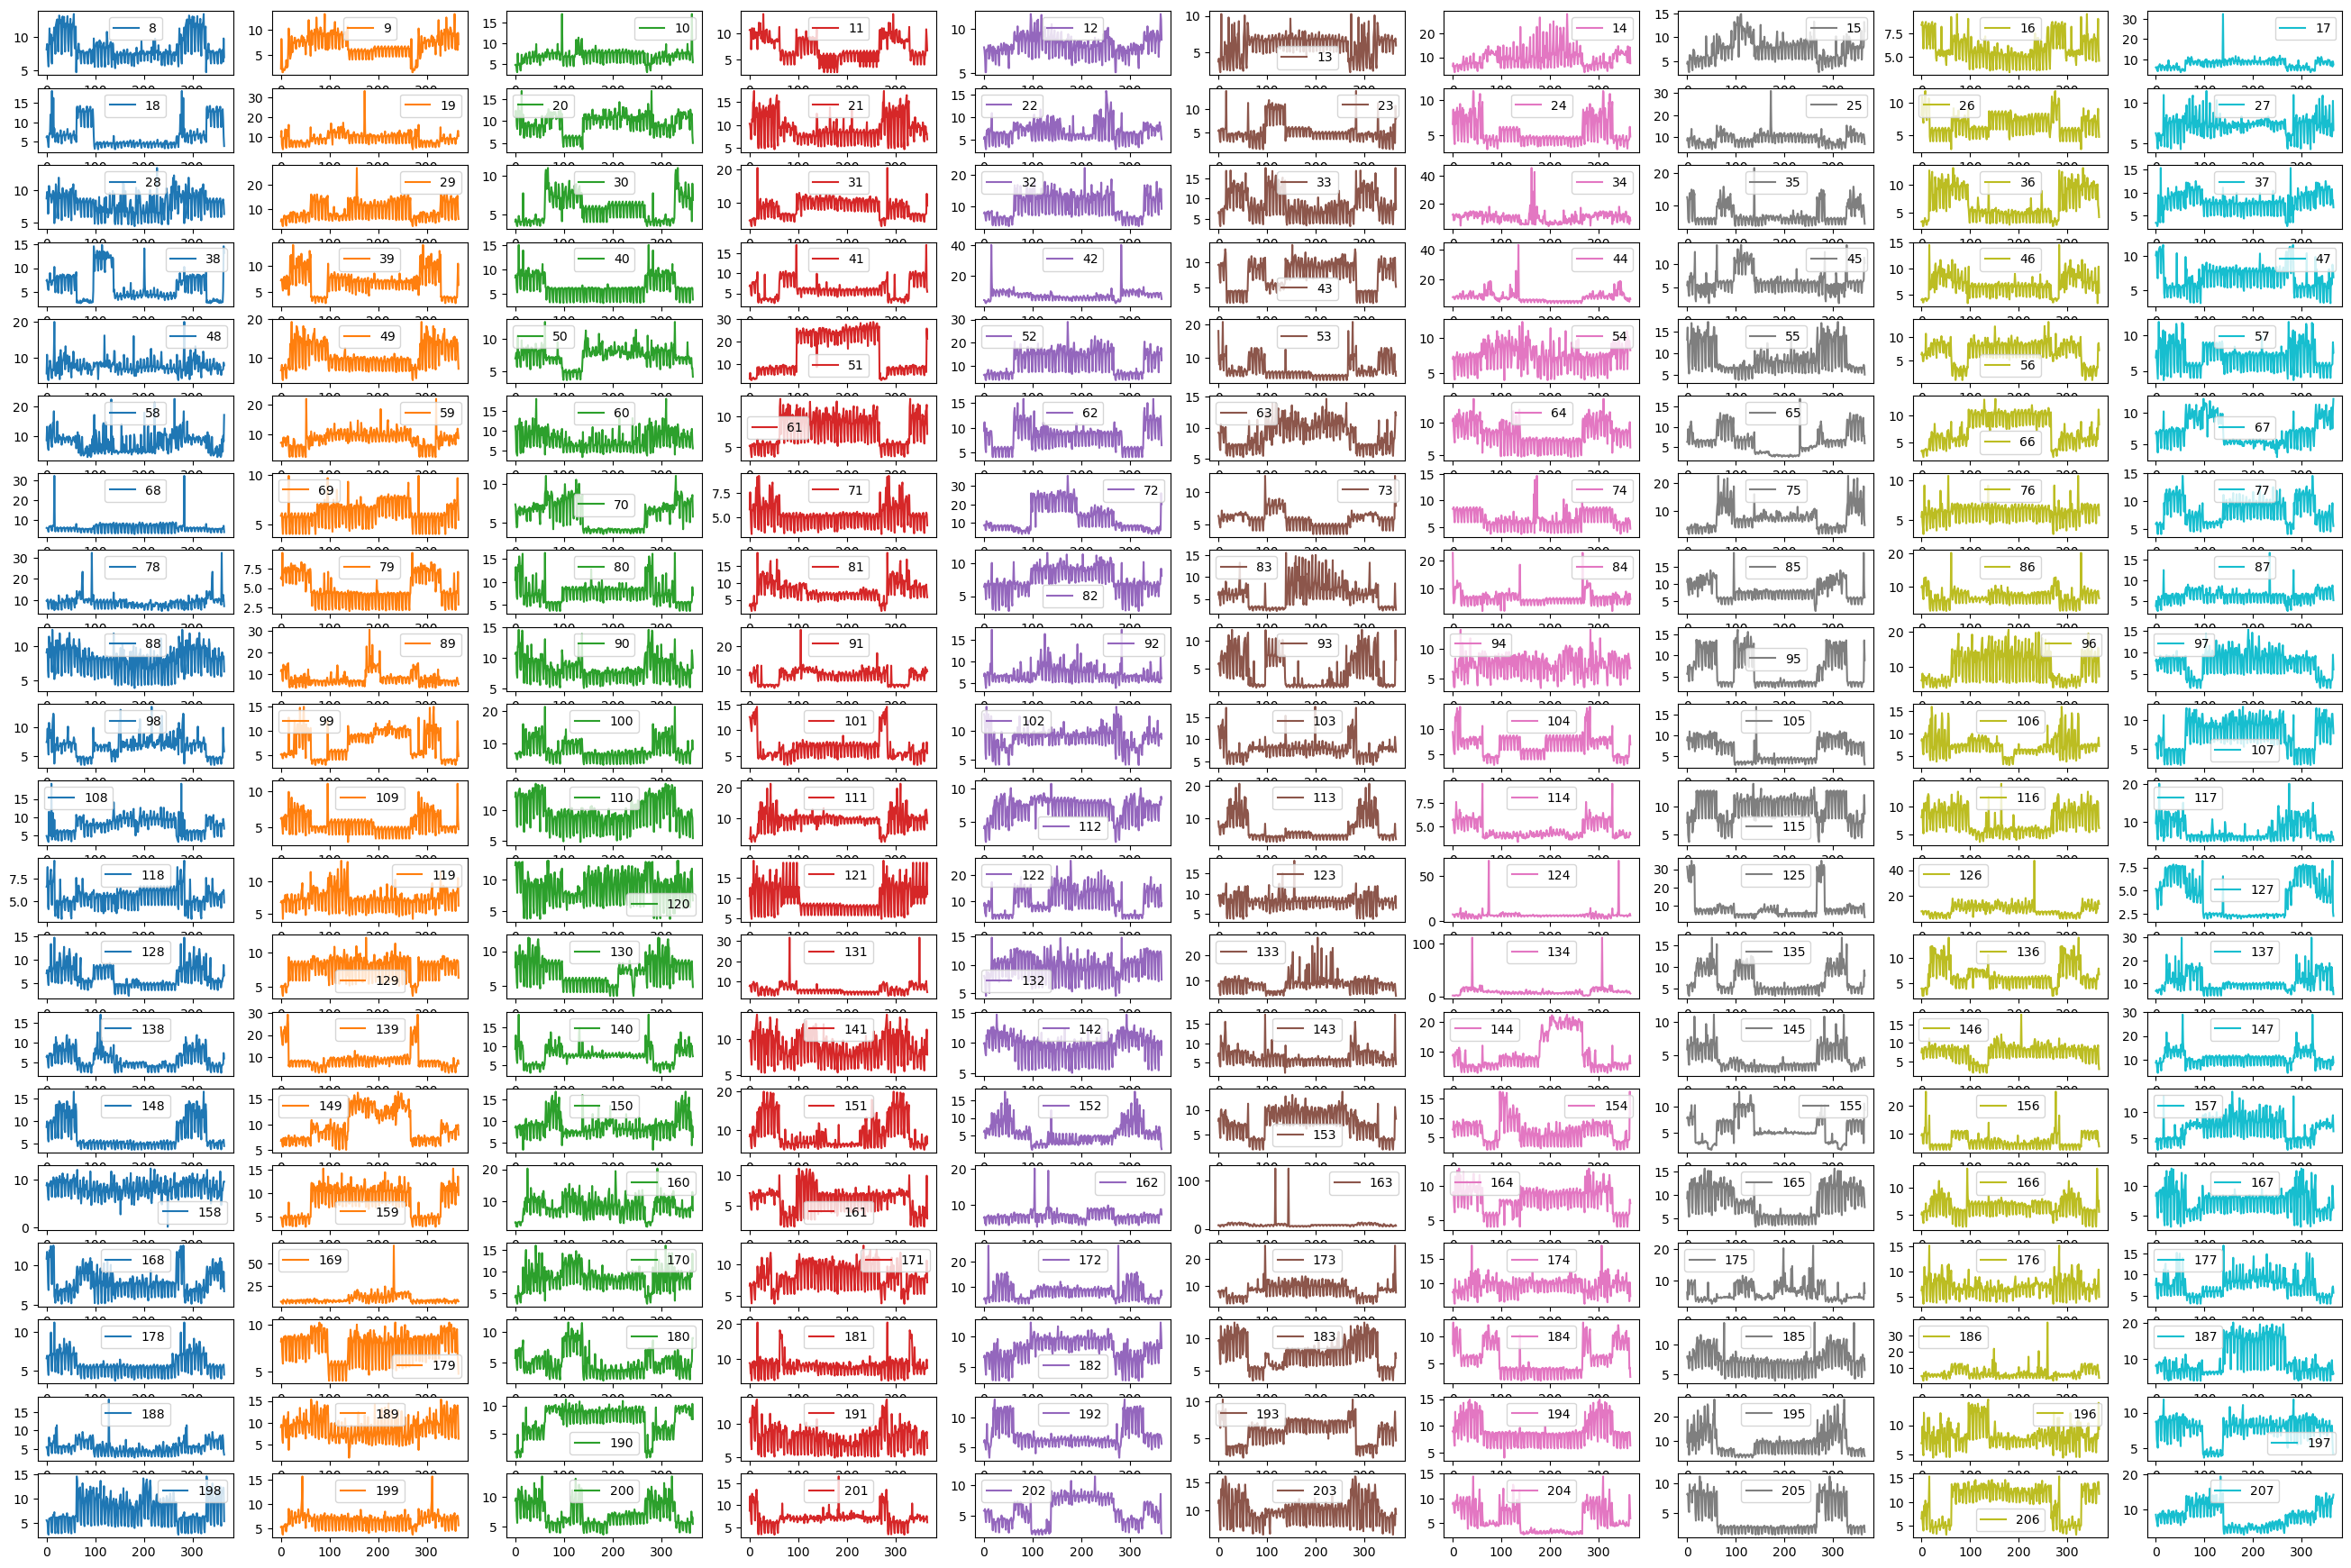

In [15]:
bottom=list(data.iloc[:,8:-2].columns.values)
fig, axes = plt.subplots(nrows=20, ncols=10,figsize=(33,22))
data[data.columns.intersection(bottom)].plot(subplots=True, ax=axes)
plt.plot();

In [16]:
#  probabalistic model with likelihood function
class model(nn.Module):
    
    def __init__(self, num_lstms, input_dim, output_dim, hidden_dim):
        super(model, self).__init__()
        self.lstm_out = hidden_dim
        self.num_lstms = num_lstms
        lstms = []
        lstms.append(nn.LSTMCell(input_dim, self.lstm_out))
        for i in range(1, self.num_lstms):
            lstms.append(nn.LSTMCell(self.lstm_out, self.lstm_out))
        self.lstms = nn.ModuleList(lstms)
        # μ and σ  distibution -> next point for every t_i.prediction length is from output dimensions
        self.mean = nn.Linear(self.lstm_out, output_dim)
        self.std = nn.Linear(self.lstm_out, output_dim)
        
    def forward(self, input, covariates, future = 0):
        dev = input.device
        means = torch.Tensor().to(dev)
        stds = torch.Tensor().to(dev)
        outputs = []
        h_t = []
        c_t = []
        cond_ctx_len = input.size(1)
        pred_ctx_len = future
        if covariates.shape[2] != 0:
            input = torch.cat((input, covariates[:, 0:cond_ctx_len, :]), 2)
        for i in range(0, self.num_lstms):
            h_t.append(torch.zeros(input.size(0), self.lstm_out, dtype=torch.float).to(dev))
            c_t.append(torch.zeros(input.size(0), self.lstm_out, dtype=torch.float).to(dev))

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t[0], c_t[0] = self.lstms[0](input_t.squeeze(1), (h_t[0], c_t[0]))
            for n in range(1, self.num_lstms):
                h_t[n], c_t[n] = self.lstms[n](h_t[n - 1], (h_t[n], c_t[n]))
            mean = self.mean(h_t[n])
            std = self.std(h_t[n])
            means = torch.cat((means, mean.unsqueeze(1)), 1)
            stds = torch.cat((stds, std.unsqueeze(1)), 1)
        stds = self.softplus(stds)
        for i in range(future):
            output_t = torch.cat((mean, covariates[:, cond_ctx_len + i, :]), 1)
            h_t[0], c_t[0] = self.lstms[0](output_t, (h_t[0], c_t[0]))
            for n in range(1, self.num_lstms):
                h_t[n], c_t[n] = self.lstms[n](h_t[n - 1], (h_t[n], c_t[n]))
            mean = self.mean(h_t[n])
            std = self.std(h_t[n])
            std = self.softplus(std) 
            means = torch.cat((means, mean.unsqueeze(1)), 1)
            stds = torch.cat((stds, std.unsqueeze(1)), 1)
        means = means.unsqueeze(-1)
        stds = stds.unsqueeze(-1)
        outputs = torch.cat((means, stds), -1)
        return outputs

    def sample(self, mean, std):
        normal_dist = torch.distributions.normal.Normal(mean, std)
        return normal_dist.sample()

    def softplus(self, x):
        softplus = torch.log(1+torch.exp(x))
        softplus = torch.where(softplus==float('inf'), x, softplus)
        return softplus

    def NLL(self, outputs, truth,AG):#negative log liklihood
        hierarchy_tot,bottom_tot=AG.shape
        mean, std = torch.split(outputs, 1, dim=3)
        AG_tensor= torch.from_numpy(AG).to(device)    
        mean = mean.squeeze(3)
        std = std.squeeze(3)
        #std=std**2
        #bottom value calculation
        bottom_mean= mean[:, :, -bottom_tot:]
        bottom_std=std[:, :, -bottom_tot:]
        #hierarchy value calculation
        Hierarchy_mean=torch.matmul(bottom_mean.float(),AG_tensor.T.float())
        Hierarchy_std=torch.matmul(bottom_std.float()**2,AG_tensor.T.float())**0.5
        #all values for loss calculation top values are hierarchy and lower values are bottom
        total_mean=torch.cat((Hierarchy_mean,bottom_mean),dim=2)
        total_std=torch.cat((Hierarchy_std,bottom_std),dim=2)
        #torch.pi = torch.acos(torch.zeros(1)).item()
        loss = torch.mean((0.5*torch.log(2*torch.pi*(total_std**2)))+torch.div(torch.sub(total_mean,truth)**2, total_std**2))
        return loss
    


# using NLL
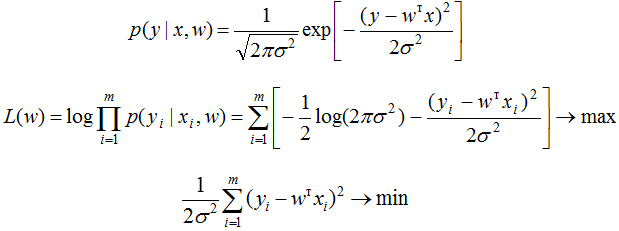!

In [17]:
'''

_params_ = {'lr': 0.01,
    'lr_step_size': 1000,
    'lr_gamma': .1,
    'ctx_win_len': 22,
    'cond_win_len': 10,
    'batch_size': 512,
    'num_covariates': 0,
    'total_num_covariates': 0,
    'num_time_idx': 0,
    'num_targets': 89,
    'total_num_targets': 89,
    'num_lstms': 2,
    'hidden_dim': 64,
    'max_batches_per_epoch': 200,
    'num_epochs': 100,
    'data_file': 'trsv.csv',
    'train_test_split':0.7
}

'''
_params_ = {'lr': 0.001,
    'lr_step_size': 100,
    'lr_gamma': 1,
    'ctx_win_len':20,
    'cond_win_len':18,
    'batch_size': 128,
    'num_covariates': 2,
    'total_num_covariates': 2,
    'num_time_idx': 1,
    'num_targets': 207,
    'total_num_targets': 207,
    'num_lstms': 2,
    'hidden_dim': 64,
    'max_batches_per_epoch':200,
    'num_epochs': 100,
    'data_file': 'trffc.csv',
    'train_test_split':0.6
            
}


In [18]:
data

,date,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,dow,dom
0,2008-01-01,1536.0182,757.3218,778.6964,360.5690,396.7528,410.6807,368.0157,8.1370,2.1910,...,9.3058,8.7667,5.8731,11.3673,8.8627,8.1654,6.5542,8.5484,1,1
1,2008-01-02,1619.2435,790.8156,828.4279,389.4334,401.3822,431.6908,396.7371,8.9488,8.1517,...,9.7310,12.0854,5.9546,11.8716,9.1413,8.2749,7.9835,7.4303,2,2
2,2008-01-03,1423.6574,684.3216,739.3358,329.0994,355.2222,387.1702,352.1656,8.1359,4.7902,...,9.6746,8.9663,6.1468,9.7029,8.5609,7.8705,6.2287,6.7340,3,3
3,2008-01-04,1096.3325,529.1279,567.2046,249.3346,279.7933,296.2565,270.9481,6.4700,1.5121,...,6.7228,6.5009,4.7770,7.6188,7.4227,5.5232,4.8793,5.8216,4,4
4,2008-01-05,974.5526,475.1733,499.3793,231.4860,243.6873,264.9305,234.4488,5.5741,1.4916,...,5.5844,5.7266,4.0254,6.4069,6.9933,5.1315,4.0133,5.2404,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2008-12-27,1606.0017,801.1668,804.8349,423.0887,378.0781,408.4916,396.3433,7.7495,9.0067,...,5.6765,6.8699,5.4110,8.9070,4.3274,2.6546,12.9457,13.0458,5,27
362,2008-12-28,1567.3015,779.7629,787.5386,413.3880,366.3749,395.4527,392.0859,8.1097,9.2325,...,7.5004,7.0521,5.5878,9.2178,4.4601,2.6299,13.1887,11.6035,6,28
363,2008-12-29,1722.5124,878.3538,844.1586,428.7631,449.5907,429.9540,414.2046,6.2941,5.9546,...,5.7080,6.9409,8.5787,7.2745,10.6823,2.8012,14.2313,13.4012,0,29
364,2008-12-30,1776.7038,918.6770,858.0268,475.8637,442.8133,421.0122,437.0146,9.7905,9.3584,...,6.5667,7.5545,2.8586,10.3623,8.6429,2.8779,14.2212,13.3731,1,30


In [19]:
class _utils:
    def __init__(self, dev,_params):
        self.min = 0
        self.max = 0
        self.range = 0
        self.mean = 0
        self.dev = dev
        self._params = _params

    def split_batch(self, batch):
        num_time_idx = self._params['num_time_idx']
        num_targets = self._params['num_targets']
        total_num_targets = self._params['total_num_targets']
        num_covariates = self._params['num_covariates']    
        b = num_time_idx
        time_idx = batch[:, 1::, :b].to(self.dev).float()
        e = b + num_targets
        input = batch[:, 0:-1, b: e].to(self.dev).float()
        target = batch[:, 1::, b: e].to(self.dev).float()
        e = e - num_targets + total_num_targets
        total_num_covariates = batch.shape[2] - e + 1  
        covariates = time_idx
        b = e
        e = b + num_covariates
        if (num_covariates > 0):
            covariates = torch.cat((time_idx, batch[:, 1::, b: e]), -1)  
        return input, target, covariates

    def scale(self, input, covariates):
        self.mean = torch.mean(input, dim=1).unsqueeze(1)
        input = input - self.mean
        self.range = torch.std(input, dim=1).unsqueeze(1)
        input = input / self.range
        num_covariates = self._params['num_covariates']
        if (num_covariates > 0):
            mean = torch.mean(covariates, dim=1).unsqueeze(1)
            covariates = covariates - mean
            min = torch.min(covariates, dim=1)[0].unsqueeze(1)
            max = torch.max(covariates, dim=1)[0].unsqueeze(1)
            range = max - min
            range[range < 1e-5] = 1e-5
            covariates = covariates / range
        return input, covariates
    
    def invert_scale(self, input, probabalistic=False):
        mean = input[:, :, :, 0]
        std = input[:, :, :, 1]
        scaled_mean = mean * self.range + self.mean
        scaled_std = std * torch.sqrt(self.range)
        return torch.cat((scaled_mean.unsqueeze(-1), scaled_std.unsqueeze(-1)), -1)

In [20]:
data.dtypes

date    datetime64[ns]
1              float64
2              float64
3              float64
4              float64
             ...      
205            float64
206            float64
207            float64
dow              int64
dom              int64
Length: 210, dtype: object

In [21]:
data.to_csv('dataset/trffc.csv')

In [22]:
class MyDataset(Dataset):
    def __len__(self):
        return self.dataset_size
    def __getitem__(self, idx):
        rel_time = torch.from_numpy(np.arange(0, self.ctx_win_len) * self.resolution).unsqueeze(1).float().to(self.dev)
        abs_time = torch.from_numpy(np.arange(idx, idx + self.ctx_win_len) * self.resolution).unsqueeze(1).float().to(
            self.dev)
        if (self.num_time_indx == 2):  
            out = torch.cat((rel_time, abs_time, self.scaled[idx: idx + self.ctx_win_len, :]), -1).unsqueeze(0)
        if (self.num_time_indx == 1):  
            out = torch.cat((rel_time, self.scaled[idx: idx + self.ctx_win_len, :]), -1).unsqueeze(0)
        if (self.num_time_indx == 0):  
            out = self.scaled[idx: idx + self.ctx_win_len, :].unsqueeze(0)
        return torch.squeeze(out, 0)
    
    def get_train_test_samplers(self, train_test_split):
        indices = list(range(self.dataset_size))
        split = int(np.floor(train_test_split * self.dataset_size))
        train_indices= indices[: split - self.ctx_win_len]
        val_indices= indices[split: split+2*self.ctx_win_len]
        test_indices =indices[split+3*self.ctx_win_len:-self.ctx_win_len]
        return train_indices,val_indices,test_indices

In [23]:
class Data_pre(MyDataset):
    def __init__(self, csv_file, dev, ctx_win_len, num_time_indx=1):
        self.num_time_indx = num_time_indx
        self.dev = dev
        df = read_csv('dataset/trffc.csv',header=0,index_col='date')
        if 'Unnamed: 0' in df.columns.values:
            df.drop('Unnamed: 0', axis=1, inplace=True)
        print(df.head())
        self.ctx_win_len = ctx_win_len
        values = df.values
        values = values.astype('float32')
        self.scaled = values
        self.dataset_size = self.scaled.shape[0]
        self.scaled = torch.from_numpy(self.scaled).float().to(dev)
        self.resolution = 1

In [24]:
params = _params_
dataset_ = Data_pre(csv_file=params['data_file'], dev=device, ctx_win_len=params['ctx_win_len'], num_time_indx=1)

                    1         2         3         4         5         6  \
date                                                                      
2008-01-01  1536.0182  757.3218  778.6964  360.5690  396.7528  410.6807   
2008-01-02  1619.2435  790.8156  828.4279  389.4334  401.3822  431.6908   
2008-01-03  1423.6574  684.3216  739.3358  329.0994  355.2222  387.1702   
2008-01-04  1096.3325  529.1279  567.2046  249.3346  279.7933  296.2565   
2008-01-05   974.5526  475.1733  499.3793  231.4860  243.6873  264.9305   

                   7       8       9      10  ...     200      201     202  \
date                                          ...                            
2008-01-01  368.0157  8.1370  2.1910  4.7163  ...  9.3058   8.7667  5.8731   
2008-01-02  396.7371  8.9488  8.1517  4.8137  ...  9.7310  12.0854  5.9546   
2008-01-03  352.1656  8.1359  4.7902  4.6435  ...  9.6746   8.9663  6.1468   
2008-01-04  270.9481  6.4700  1.5121  3.2586  ...  6.7228   6.5009  4.7770   
2008-0

In [25]:
config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }

In [26]:
num_covariates = params['num_covariates']
num_time_idx = params['num_time_idx']
num_targets = params['num_targets']
input_dim = num_time_idx + num_targets + num_covariates
ctx_win_len = params['ctx_win_len']
cond_win_len = params['cond_win_len']
pred_win_len = ctx_win_len - cond_win_len - 1
batch_size = params['batch_size']

In [27]:
model = model(num_lstms=params['num_lstms'], input_dim=input_dim, output_dim=params['num_targets'],hidden_dim=params['hidden_dim']).to(device)
optimizer = optim.Adam(model.parameters(), params['lr'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=params['lr_step_size'], gamma=params['lr_gamma'])

In [28]:
train_, val_,test_ = dataset_.get_train_test_samplers(params['train_test_split'])

In [29]:
train_sampler=SubsetRandomSampler(train_)
val_sampler=SubsetRandomSampler(val_)
test_sampler=SubsetRandomSampler(test_)

In [30]:
train_dataloader = DataLoader(dataset_, batch_size=32, sampler=train_sampler, shuffle=False, num_workers=0)
val_dataloader= DataLoader(dataset_, batch_size=32, sampler=val_sampler, shuffle=False, num_workers=0)
test_dataloader = DataLoader(dataset_, batch_size=10, sampler=test_sampler,shuffle=False, num_workers=0)
max_batches_per_epoch = params['max_batches_per_epoch']
num_epochs = params['num_epochs']

In [31]:
def test_plot(out,target,AG,epoch):
    for v in range(out.shape[0]):
        preds = out[0, :, :, :].detach().cpu().numpy()
        targets = target[0, :, :].detach().cpu().numpy()
        preds[:,0:7, 0]=preds[:,7:207, 0]@AG.T
        preds[:,0:7, 1]=((preds[:,7:207, 1])**2@AG.T)**0.5    
    for j in range(7):
        pred = preds[:, j, 0]  
        std = preds[:, j, 1]  
        targe = targets[:, j]
        plt.figure()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xticks()
        plt.yticks()
        plt.plot(np.arange(len(targe)), targe, 'r', linewidth=2.0)
        plt.plot(np.arange(cond_win_len), pred[0:cond_win_len], 'b', linewidth=2.0)
        plt.plot(np.arange(cond_win_len, cond_win_len + pred_win_len), pred[cond_win_len:], 'g' + ':',
                 linewidth=2.0)
        plt.fill_between(np.arange(len(targe)), pred - std, pred + std, color='cyan', alpha=0.5)
        plt.fill_between(np.arange(len(targe)), pred - 2 * std, pred + 2 * std, color='cyan', alpha=0.2)
        plt.title(j)
        #text='figures/'+str(epoch)+str(f"{j:02d}")
        plt.show() # save the figure to file
        plt.close()

In [32]:
def CRPS_test(out,target,AG):
    for v in range(out.shape[0]):
        preds = out[0, :, :, :].detach().cpu().numpy()
        targets = target[0, :, :].detach().cpu().numpy()
        preds[:,0:7, 0]=preds[:,7:207, 0]@AG.T
        preds[:,0:7, 1]=((preds[:,7:207, 1])**2@AG.T)**0.5 
    k=ps.crps_gaussian(targets, mu= preds[:, :, 0], sig=preds[:, :, 1])
    return(np.mean(k))

In [33]:
def test_check(_dataloader,model,AG):
    ls,vcrps=[],[]
    for i, batch in enumerate(_dataloader):
        with torch.no_grad():
            model.eval()
            input, target, covariates = utils.split_batch(batch)
            input, covariates = utils.scale(input, covariates)
            pred = model(input[:, 0:cond_win_len, :], covariates, future=pred_win_len)
            pred = utils.invert_scale(pred, True)
            loss = model.NLL(pred, target,AG)
            ls.append(loss.item())
            vcrps.append(CRPS_test(pred,target,AG))
            #print("Val: {0}".format(loss))
    print("Val_CRPS: {0}".format(mean(vcrps)))
    print("Val_loss: {0}".format(mean(ls)))        

In [34]:
losses = []
batch_num = 1
utils = _utils(device, params)
# Trainin loop
def train():
    for epoch in range(0, num_epochs):
        batch_num = 0
        print(f"epoch:{epoch} /{num_epochs}")
        for i, batch in enumerate(train_dataloader):
            if batch_num > max_batches_per_epoch:
                break
            input, target, covariates = utils.split_batch(batch) 
            #splitting batches : issue with sequence
            #conditioning window input,Prediction window , model op conditioned on previous values
            # model output for the previous step
            input_cond = input[:, 0:cond_win_len, :]
            input_cond, covariates = utils.scale(input_cond, covariates)
            optimizer.zero_grad()
            #forward pass
            out = model(input_cond, covariates, future=pred_win_len)
            out = utils.invert_scale(out)
            #rescale
            #test_plot(out,target,AG,epoch)
            print('Train CRPS:',CRPS_test(out,target,AG))
            loss = model.NLL(out, target,AG)
            #loss calc
            loss.backward()
            scheduler.step()
            optimizer.step()
            loss = loss.item()
            losses.append(loss)
            print(f"epoch:{epoch} /{num_epochs}")
            print("Train loss: {0}".format(loss))
            test_check(val_dataloader,model,AG)
            print('─' * 30)
            batch_num = batch_num + 1
    return model, losses

In [35]:
model, losses = train()

epoch:0 /100
Train CRPS: 3.9454103
epoch:0 /100
Train loss: 9.6033935546875
Val_CRPS: 3.542776107788086
Val_loss: 8.989024639129639
──────────────────────────────
Train CRPS: 4.0452623
epoch:0 /100
Train loss: 9.072888374328613
Val_CRPS: 3.450754165649414
Val_loss: 8.783071041107178
──────────────────────────────
Train CRPS: 4.3778276
epoch:0 /100
Train loss: 8.795296669006348
Val_CRPS: 3.3379034996032715
Val_loss: 8.925098419189453
──────────────────────────────
Train CRPS: 3.3822117
epoch:0 /100
Train loss: 8.99655532836914
Val_CRPS: 3.5370004177093506
Val_loss: 8.603693008422852
──────────────────────────────
Train CRPS: 4.6352615
epoch:0 /100
Train loss: 8.69607162475586
Val_CRPS: 3.4053640365600586
Val_loss: 8.57287883758545
──────────────────────────────
Train CRPS: 4.3007793
epoch:0 /100
Train loss: 8.687271118164062
Val_CRPS: 3.4244749546051025
Val_loss: 8.28929090499878
──────────────────────────────
Train CRPS: 3.6587176
epoch:0 /100
Train loss: 8.45560359954834
Val_CRPS: 3.1

In [82]:
loss_crps=[]
for i, batch in enumerate(test_dataloader):
    with torch.no_grad():
        input, target, covariates = utils.split_batch(batch)
        input, covariates = utils.scale(input, covariates)
        pred = model(input[:, 0:cond_win_len, :], covariates, future=pred_win_len)
        pred = utils.invert_scale(pred, True)
        loss = model.NLL(pred, target,AG)
        print("loss (prediction): {0}".format(loss))
        preds = pred[0, :, :, :].detach().cpu().numpy()
        targets = target[0, :, :].detach().cpu().numpy()
        preds[:,0:7, 0]=preds[:,7:207, 0]@AG.T
        preds[:,0:7, 1]=((preds[:,7:207, 1])**2@AG.T)**0.5
        mm= preds[:, :, 0]  
        std = preds[:, :, 1]
        print('CRPS:',np.mean(ps.crps_gaussian(targets[-pred_win_len:], mu=mm[-pred_win_len:], sig=std[-pred_win_len:])))
    '''
    for j in range(num_targets):
        pred = preds[:, j, 0]  
        std = preds[:, j, 1]  
        target = targets[:, j]
        plt.figure()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xticks()
        plt.yticks()
        plt.plot(np.arange(len(target[cond_win_len:])), target[cond_win_len:], 'r', linewidth=2.0,label="Target")
        #plt.plot(np.arange(cond_win_len)[cond_win_len:], pred[cond_win_len:], 'b', linewidth=2.0)
        plt.plot(np.arange(ctx_win_len-cond_win_len-1), pred[cond_win_len:], 'g' + ':',
                 linewidth=2.0,label="Prediction")
        plt.fill_between(np.arange(len(target[cond_win_len:])), pred[cond_win_len:] - std[cond_win_len:], pred[cond_win_len:] + std[cond_win_len:], color='cyan', alpha=0.5,label="Standard Deviation")
        #plt.fill_between(np.arange(len(target)), pred - 2 * std, pred + 2 * std, color='cyan', alpha=0.2)
        title='Serie:'+str(j)
        plt.title(title)
        plt.legend(loc="lower right")'''

loss (prediction): 1.6574698686599731
CRPS: 0.7217286
loss (prediction): 1.5698820352554321
CRPS: 0.5608314
loss (prediction): 1.715657114982605
CRPS: 0.7535239
loss (prediction): 1.6967047452926636
CRPS: 0.8247344
loss (prediction): 1.7028961181640625
CRPS: 0.6626429
loss (prediction): 1.6229884624481201
CRPS: 1.1049943
loss (prediction): 1.6344648599624634
CRPS: 0.7400718
